In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, CondensedNearestNeighbour, OneSidedSelection

from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import pyreadstat

from matplotlib import rc
%matplotlib inline
rc('font', family='Arial Unicode MS')

#### 함수들

In [4]:
# preprocessed
def getFirstData(outlierCol=None):

    data = pd.read_csv('../CVD_cleaned.csv')

    if outlierCol != None:
        # outlier 제거
        # outlier를 제거할 column
        selected_columns = outlierCol

        # IQR 계산
        Q1 = data[selected_columns].quantile(0.25)
        Q3 = data[selected_columns].quantile(0.75)
        IQR = Q3 - Q1

        # weight
        threshold = 1.5

        outlier_mask = (
            (data[selected_columns] < (Q1 - threshold * IQR)) |
            (data[selected_columns] > (Q3 + threshold * IQR))
        ).any(axis=1)

        # outlier 제거
        data_nooutlier = data[~outlier_mask]
        data = data_nooutlier



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-24': 0,
        '25-29': 1,
        '30-34': 2,
        '35-39': 3,
        '40-44': 4,
        '45-49': 5,
        '50-54': 6,
        '55-59': 7,
        '60-64': 8,
        '65-69': 9,
        '70-74': 10,
        '75-79': 11,
        '80+': 12
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)  

    return data


# age category 변경
def getSecData():
    data = pd.read_csv('../CVD_cleaned.csv')

    # age category 변경
    data.loc[(data['Age_Category']=='18-24') | (data['Age_Category']=='25-29'), 'Age_Category'] = '18-29'
    data.loc[(data['Age_Category']=='30-34') | (data['Age_Category']=='35-39'), 'Age_Category'] = '30-39'
    data.loc[(data['Age_Category']=='40-44') | (data['Age_Category']=='45-49'), 'Age_Category'] = '40-49'
    data.loc[(data['Age_Category']=='50-54') | (data['Age_Category']=='55-59'), 'Age_Category'] = '50-59'
    data.loc[(data['Age_Category']=='60-64') | (data['Age_Category']=='65-69'), 'Age_Category'] = '60-69'
    data.loc[(data['Age_Category']=='70-74') | (data['Age_Category']=='75-79'), 'Age_Category'] = '70-79'



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-29': 0,
        '30-39': 1,
        '40-49': 2,
        '50-59': 3,
        '60-69': 4,
        '70-79': 5,
        '80+': 6
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)   

    return data




# 모델 train, test scores 각각 반환
def train_test_scores(X, y, test_size=0.2, 
                      model=None,
                      scaler=None,
                      pipe=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    tmp = []

    if model != None:
        if model == 'lr':
            clf = LogisticRegression(random_state=13)

        elif model == 'dt':
            clf = DecisionTreeClassifier(random_state=13)

        elif model == 'rf':
            clf = RandomForestClassifier(random_state=13)

        elif model == 'lgbm':
            clf = LGBMClassifier(random_state=13)

        elif model == 'xgboost':
            clf = XGBClassifier(random_state=13)
        
        name = model

    elif pipe != None:
        clf = pipe

    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train) # train
    pred = clf.predict(X_test) # test

    acc_train = accuracy_score(y_train, pred_train)
    pre_train = precision_score(y_train, pred_train)
    re_train = recall_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train)
    aucc_train = roc_auc_score(y_train, pred_train)

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    aucc = roc_auc_score(y_test, pred)

    # 결과 df로 저장
    tmp.append([f'{name}_clf_train', acc_train, pre_train, re_train, f1_train, aucc_train])
    tmp.append([f'{name}_clf_test', acc, pre, re, f1, aucc])

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# 모든 모델 resample 적용 후 반환
def resample_scores_all(X, y, test_size=0.2, 
                      scaler=None,
                      resample=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    if resample != None: 
        # resample
        X_train, y_train = resample.fit_resample(X_train, y_train)

    models = [LogisticRegression(random_state=13), DecisionTreeClassifier(random_state=13), 
              RandomForestClassifier(random_state=13), LGBMClassifier(random_state=13), 
              XGBClassifier(random_state=13)]

    tmp = []

    for clf in models:
        clf.fit(X_train, y_train)
        pred_train = clf.predict(X_train) # train
        pred = clf.predict(X_test) # test

        acc_train = accuracy_score(y_train, pred_train)
        pre_train = precision_score(y_train, pred_train)
        re_train = recall_score(y_train, pred_train)
        f1_train = f1_score(y_train, pred_train)
        aucc_train = roc_auc_score(y_train, pred_train)

        acc = accuracy_score(y_test, pred)
        pre = precision_score(y_test, pred)
        re = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        aucc = roc_auc_score(y_test, pred)

        name = str(clf).split('(')[0]

        # 결과 df로 저장
        tmp.append([f'{name}_train', acc_train, pre_train, re_train, f1_train, aucc_train])
        tmp.append([f'{name}_test', acc, pre, re, f1, aucc])

  

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# 첫 번쨰 ml 파일 21번에서 column 삭제, 파라미터 변경
- threshold=0.7, C=0.001, max_iter=1000
- svmsmote, standardscaler

In [26]:
data = getFirstData()
X = data.drop(["Heart_Disease", 'Arthritis',
 'FriedPotato_Consumption',
 'Fruit_Consumption',
 'Green_Vegetables_Consumption',
 'Smoking_History',
 'Weight_(kg)'], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=13, 
                                                        stratify=y)

resample = SVMSMOTE(random_state=13)
X_train, y_train = resample.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=13,
                           C=0.001, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

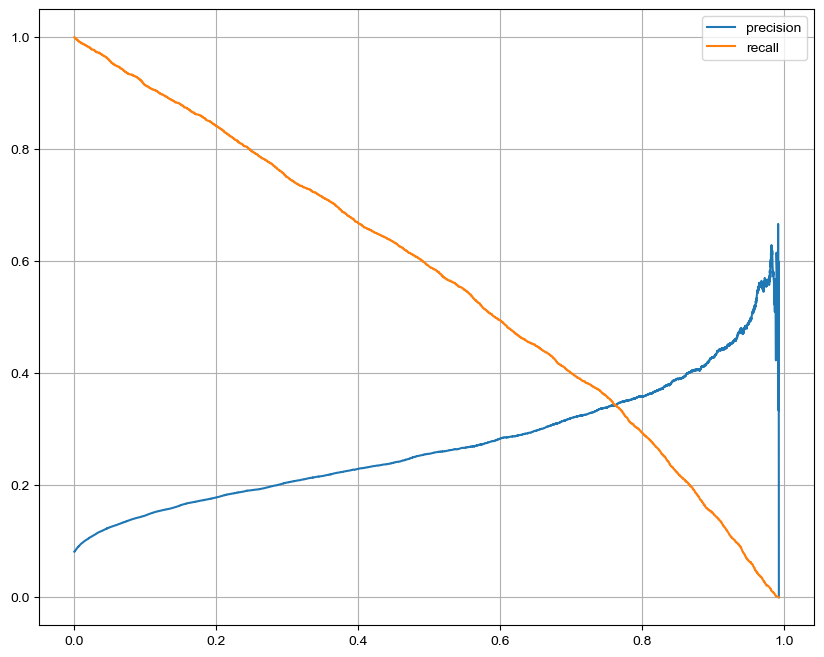

In [27]:
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

precision_recall curve 보고 적당한 임게점(0.7) 찾아서 적용

In [40]:
predd = model.predict_proba(X_test)[:, 1]

# 임계값 변경
thresholdChanged = (predd>=0.7).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tmp = []
tmp.append(['lr (threshold=0.7, C=0.001, max_iter=1000)', acc, pre, re, f1, aucc])
df = pd.DataFrame(tmp, columns=cols)

In [41]:
df

,memo,accuracy,precision,recall,f1,roc_auc
0,"lr (threshold=0.7, C=0.001, max_iter=1000)",0.882663,0.319853,0.400681,0.355733,0.662869


# 오답 추가분석

In [48]:
pred_threshold = list((model.predict_proba(X_test)[:, 1] >= 0.7).astype(int))

In [70]:
X_test.shape

(61771, 13)

In [79]:
cols = list(X.columns)

In [105]:
len(tmp)

61771

In [134]:
X_test_smote = pd.DataFrame(list(scaler.inverse_transform(X_test)), columns=cols)

In [135]:
X_test_smote

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Age_Category,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male
0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,9.0,170.0,25.84,4.0,0.0,1.0
1,3.0,4.0,1.0,0.0,0.0,1.0,0.0,4.0,183.0,27.12,0.0,0.0,1.0
2,4.0,4.0,1.0,0.0,0.0,0.0,0.0,7.0,180.0,30.68,0.0,0.0,1.0
3,3.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,178.0,25.11,30.0,0.0,1.0
4,3.0,3.0,1.0,0.0,0.0,0.0,0.0,12.0,170.0,29.76,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,2.0,4.0,0.0,0.0,1.0,0.0,0.0,11.0,157.0,27.07,0.0,1.0,0.0
61767,4.0,4.0,1.0,0.0,0.0,0.0,0.0,10.0,178.0,27.26,0.0,0.0,1.0
61768,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,196.0,16.60,12.0,0.0,1.0
61769,4.0,4.0,1.0,0.0,0.0,0.0,0.0,9.0,185.0,25.73,12.0,0.0,1.0


In [136]:
X_test_smote['Heart_Disease'] = list(y_test)
X_test_smote['predicted'] = pred_threshold

In [137]:
X_test_smote

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Age_Category,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male,Heart_Disease,predicted
0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,9.0,170.0,25.84,4.0,0.0,1.0,0,0
1,3.0,4.0,1.0,0.0,0.0,1.0,0.0,4.0,183.0,27.12,0.0,0.0,1.0,0,0
2,4.0,4.0,1.0,0.0,0.0,0.0,0.0,7.0,180.0,30.68,0.0,0.0,1.0,0,0
3,3.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,178.0,25.11,30.0,0.0,1.0,0,0
4,3.0,3.0,1.0,0.0,0.0,0.0,0.0,12.0,170.0,29.76,0.0,0.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,2.0,4.0,0.0,0.0,1.0,0.0,0.0,11.0,157.0,27.07,0.0,1.0,0.0,0,0
61767,4.0,4.0,1.0,0.0,0.0,0.0,0.0,10.0,178.0,27.26,0.0,0.0,1.0,0,0
61768,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,196.0,16.60,12.0,0.0,1.0,0,0
61769,4.0,4.0,1.0,0.0,0.0,0.0,0.0,9.0,185.0,25.73,12.0,0.0,1.0,0,0


### tp, fp, tn, fn 분류

In [140]:
right = []
wrong = []

for idx, row in X_test_smote.iterrows():
    if row['Heart_Disease'] == row['predicted']:
        right.append(idx)
    elif row['Heart_Disease'] != row['predicted']:
        wrong.append(idx)

right_df = X_test_smote.loc[right]
wrong_df = X_test_smote.loc[wrong]

In [142]:
tp = right_df[right_df['predicted']==1]  # 양성
tn = right_df[right_df['predicted']==0]  # 음성

fp = wrong_df[wrong_df['predicted']==1]  # 음성인데 양성이라고 예측
fn = wrong_df[wrong_df['predicted']==0]  # 양성인데 음성이라고 예측

In [146]:
def compare(fn, fp, tn, tp, col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    x_range = (min(X[col]), max(X[col]))

    # wrong
    axes[0].hist(fn[col], color='orange', alpha=0.5, label='가짜 음성', rwidth=0.8, bins=range(0, int(x_range[1])+2))
    axes[0].hist(fp[col], color='blue', alpha=0.3, label='가짜 양성', rwidth=0.8, bins=range(0, int(x_range[1])+2))
    # 범례 추가
    axes[0].legend()
    axes[0].set_title(f'wrong - {col}')

    # right
    axes[1].hist(tn[col], color='blue', alpha=0.3, label='음성', rwidth=0.8, bins=range(0, int(x_range[1])+2))
    axes[1].hist(tp[col], color='orange', alpha=0.5, label='양성', rwidth=0.8, bins=range(0, int(x_range[1])+2))
    # 범례 추가
    axes[1].legend()
    axes[1].set_title(f'right - {col}')

    plt.show()

### 정답 분류와 오답 분류 비교

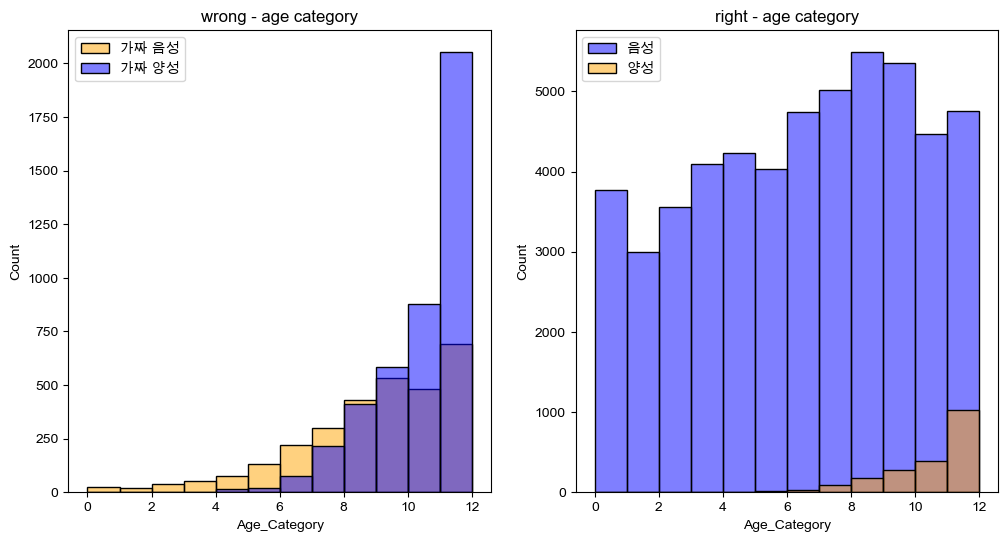

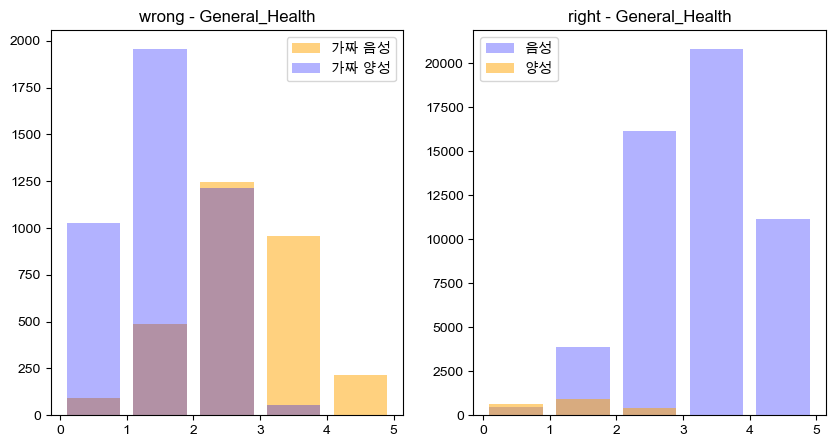

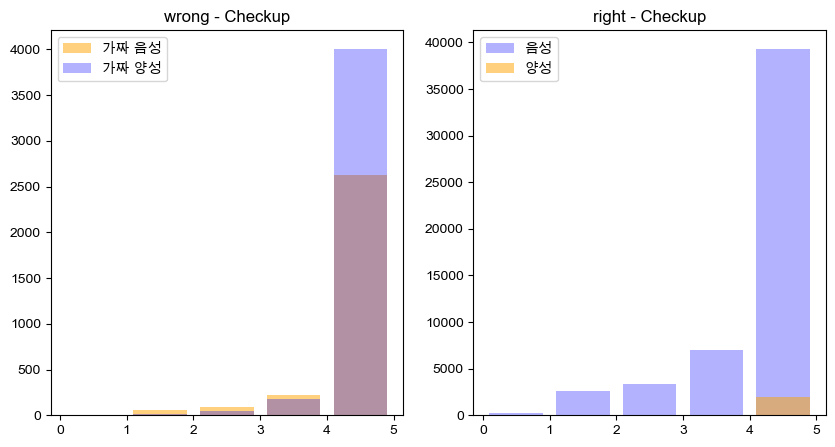

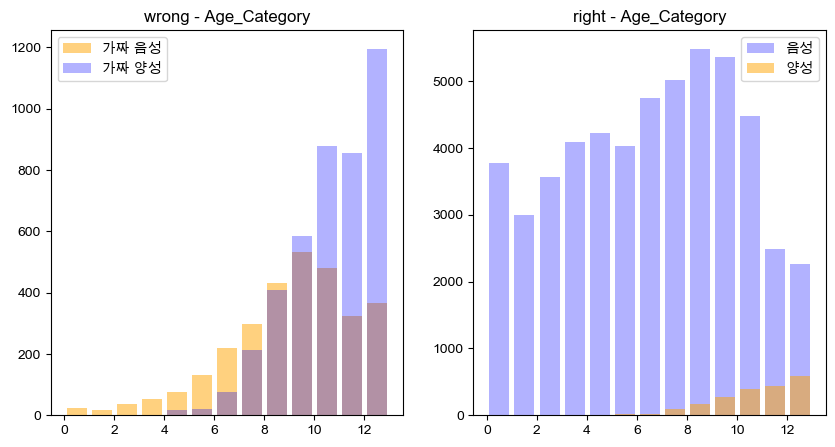

In [147]:
# 히스토그램 겹치게 그리기
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(fn['Age_Category'], color='orange', alpha=0.5, label='가짜 음성', ax=ax[0], bins=range(0, 13))
sns.histplot(fp['Age_Category'], color='blue', alpha=0.5, label='가짜 양성', ax=ax[0], bins=range(0, 13))

# 그래프에 제목과 레이블 추가
ax[0].set_title('wrong - age category')
# 범례 추가
ax[0].legend()

sns.histplot(tn['Age_Category'], color='blue', alpha=0.5, label='음성', ax=ax[1], bins=range(0, 13))
sns.histplot(tp['Age_Category'], color='orange', alpha=0.5, label='양성', ax=ax[1], bins=range(0, 13))

# 그래프에 제목과 레이블 추가
ax[1].set_title('right - age category')
# 범례 추가
ax[1].legend()

# 그래프 표시
# def compare(fn, fp, tn, tp, col):
for col in ['General_Health', 'Checkup', 'Age_Category']:
    compare(fn, fp, tn, tp, col)

- 나이대가 높으면 심장병 양성으로 분류하는 경향 있음
- checkup이 높으면 심장병 음성으로 분류하는 경향 있음 (wrong - checkup의 가짜 음성 높음)
- general_health 가 낮으면 양성, 높으면 음성으로 분류하는 경향 있음

# 수정1. 나이대 12 (85세 이상 drop)

In [148]:
data = getFirstData()
data = data[data['Age_Category']<12]
X = data.drop(["Heart_Disease", 'Arthritis',
 'FriedPotato_Consumption',
 'Fruit_Consumption',
 'Green_Vegetables_Consumption',
 'Smoking_History',
 'Weight_(kg)'], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=13, 
                                                        stratify=y)

resample = SVMSMOTE(random_state=13)
X_train, y_train = resample.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=13,
                           C=0.001, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

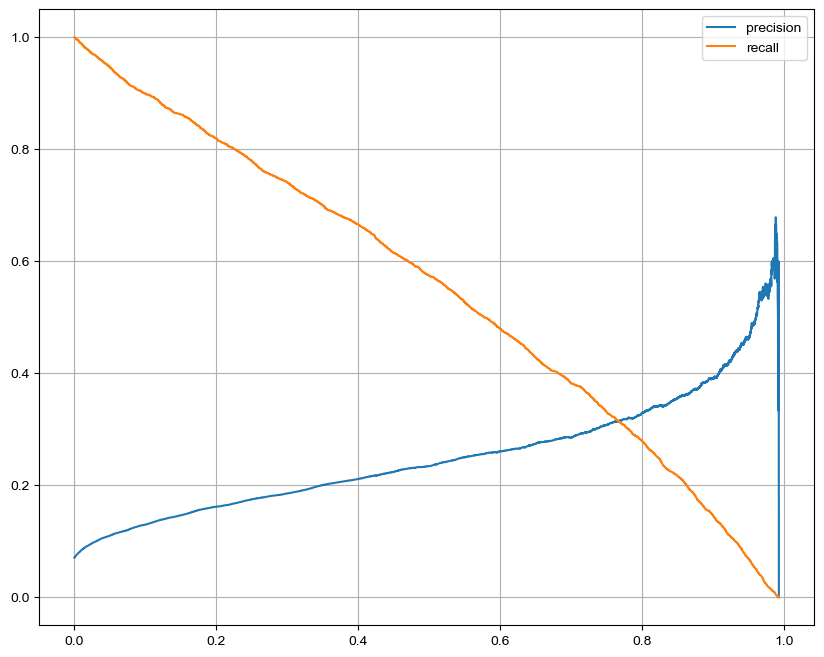

In [149]:
# precision - recall curve
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

In [154]:
predd = model.predict_proba(X_test)[:, 1]

# 임계값 변경
thresholdChanged = (predd>=0.75).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tmp = []
tmp.append(['lr (threshold=0.7, C=0.001, max_iter=1000)', acc, pre, re, f1, aucc])
df = pd.DataFrame(tmp, columns=cols)

In [155]:
df

,memo,accuracy,precision,recall,f1,roc_auc
0,"lr (threshold=0.7, C=0.001, max_iter=1000)",0.90078,0.307941,0.331593,0.31933,0.63767


precision_recall_curve 을 확인하고 임계점을 0.75로 변경했으나, 85세 이상을 제외하기 전에 비해 성능이 떨어졌다. 

# 수정 2. General_Health 0, 5인 데이터 drop

In [156]:
data = getFirstData()
data = data[(data['General_Health']>0) & (data['General_Health']<5)]
X = data.drop(["Heart_Disease", 'Arthritis',
 'FriedPotato_Consumption',
 'Fruit_Consumption',
 'Green_Vegetables_Consumption',
 'Smoking_History',
 'Weight_(kg)'], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=13, 
                                                        stratify=y)

resample = SVMSMOTE(random_state=13)
X_train, y_train = resample.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=13,
                           C=0.001, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

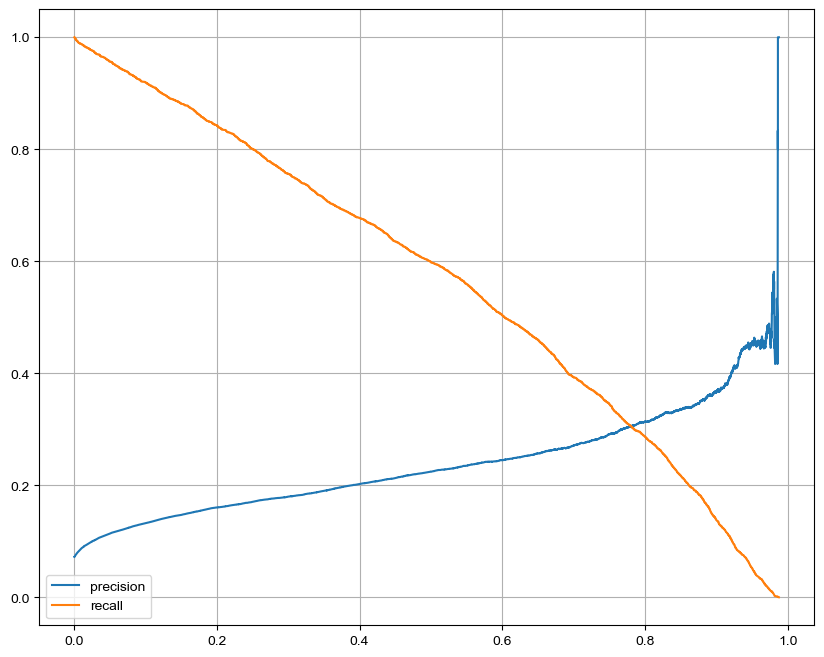

In [157]:
# precision - recall curve
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

In [172]:
predd = model.predict_proba(X_test)[:, 1]

# 임계값 변경
thresholdChanged = (predd>=0.77).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tmp = []
tmp.append(['lr (threshold=0.7, C=0.001, max_iter=1000)', acc, pre, re, f1, aucc])
df = pd.DataFrame(tmp, columns=cols)

In [173]:
df

,memo,accuracy,precision,recall,f1,roc_auc
0,"lr (threshold=0.7, C=0.001, max_iter=1000)",0.89816,0.301379,0.317033,0.309008,0.630081


성능 개선이 딱히 없다. 